# Windows of oportunities from initial conditions of optimal growth

In [1]:
import os, torch, nc_time_axis, yaml
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
from importlib import reload
import hyblim.geoplot as gpl
from hyblim.data import preproc, eof
from hyblim.utils import metric, enso

plt.style.use("../../paper.mplstyle")

def get_model_specs_by_name(experiments, exp_name):
    for exp in experiments:
        if exp['name'] == exp_name:
            return exp 
    return None

# Load list of experiments
with open("experiments.yaml", "r") as f:
    experiments = yaml.safe_load(f)

## Load data

In [2]:
datapaths = {}
datapaths['ssta'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssta_lat-31_33_lon130_290_gr1.0.nc"
datapaths['ssha'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssha_lat-31_33_lon130_290_gr1.0.nc"

da_arr, normalizer = [], {}
for var, path in datapaths.items():
    da = xr.open_dataset(path)[var]
    # Normalize data 
    normalizer_var = preproc.Normalizer()
    da = normalizer_var.fit_transform(da)
    # Store normalizer as an attribute in the Dataarray for the inverse transformation
    da.attrs = normalizer_var.to_dict()
    da_arr.append(da)
    normalizer[var] = normalizer_var

ds = xr.merge(da_arr)

# Apply land sea mask
lsm = xr.open_dataset("../../data/land_sea_mask_common.nc")['lsm']
ds = ds.where(lsm!=1, other=np.nan)

nino_indices = enso.get_nino_indices(ds['ssta'])

In [3]:
# Create PCA
n_eof = [20,10]
eofa_lst = []
for i, var in enumerate(ds.data_vars):
    print(f"Create EOF of {var}!")
    n_components = n_eof[i] if isinstance(n_eof, list) else n_eof 
    eofa = eof.EmpiricalOrthogonalFunctionAnalysis(n_components)
    eofa.fit(
        ds[var].isel(time=slice(None, int(0.8*len(ds['time']))))
    )
    eofa_lst.append(eofa)
combined_eof = eof.CombinedEOF(eofa_lst, vars=list(ds.data_vars))

Create EOF of ssta!
Create EOF of ssha!


In [4]:
# Split in training and test data
train_period = (0, int(0.8*len(ds['time'])))
val_period = (int(0.8*len(ds['time'])), int(0.9*len(ds['time'])))
test_period = ( int(0.9*len(ds['time'])), len(ds['time']) ) 

data = dict(
    train = combined_eof.transform(ds.isel(time=slice(*train_period))),
    val = combined_eof.transform(ds.isel(time=slice(*val_period))),
    test = combined_eof.transform(ds.isel(time=slice(*test_period))),
)

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_times = ds.dims['time']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/data/eof.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dat

## Load opitimal initial patterns and their evolution

In [5]:
optimal_init_pc = xr.open_dataarray("../../models/lim/cslim_ssta-ssha/metrics/optimal_init_pc.nc")
optimal_evolved_pc = xr.open_dataarray("../../models/lim/cslim_ssta-ssha/metrics/optimal_evolved_pc.nc")
optimal_init_map = xr.open_dataset("../../models/lim/cslim_ssta-ssha/metrics/optimal_init_map.nc")
optimal_evolved_map = xr.open_dataset("../../models/lim/cslim_ssta-ssha/metrics/optimal_evolved_map.nc")
optimal_init_map = -1* optimal_init_map / optimal_init_map.std()
optimal_evolved_map = -1* optimal_evolved_map / optimal_evolved_map.std()

### Plot initial conditions

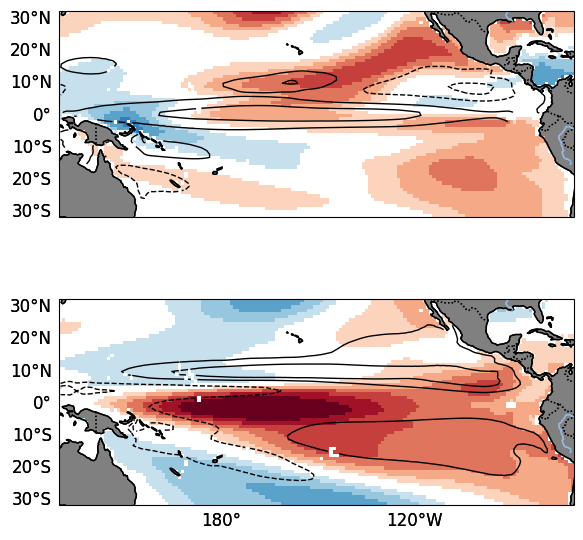

In [6]:
init_month, tau = 4, 12
pltargs = {'ssta': dict(vmin=-3, vmax=3, eps=0.5, cmap='RdBu_r', centercolor='white'),
           'ssha': dict(kwargs_pl={'colors':'k', 'levels' :[-2.5, -1.25, 1.25, 2.5], 
                            'linewidths': 1}, zerolinecolor=None, add_inline_labels=False)}
# Optimal initial pattern
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(2,1,1, projection=ctp.crs.PlateCarree(central_longitude=180))
im = gpl.plot_map(optimal_init_map['ssta'].sel(month=init_month, lag=tau), ax=ax, 
                  **pltargs['ssta'], add_bar=False,
                  kwargs_cb=dict(label="Optimal initial", orientation='horizontal')
)
im2 = gpl.plot_contour(optimal_init_map['ssha'].sel(month=init_month, lag=tau), ax=ax,
                       **pltargs['ssha'], kwargs_labels=dict(fmt='%.2f'))
#ax.set_title("Optimal initial")
im['gl'].bottom_labels = False
im2['gl'].bottom_labels = False

# Optimal evolved pattern
ax = fig.add_subplot(2,1,2, projection=ctp.crs.PlateCarree(central_longitude=180))
im = gpl.plot_map(optimal_evolved_map['ssta'].sel(month=init_month, lag=tau), ax=ax, 
                  **pltargs['ssta'], add_bar=False,
                  kwargs_cb=dict(label="Evolved optimal initial", orientation='horizontal')
)
im2 = gpl.plot_contour(optimal_evolved_map['ssha'].sel(month=init_month, lag=tau), ax=ax,
                       **pltargs['ssha'],
                       kwargs_labels=dict(fmt='%.2f'))

## Project initial conditions on data

In [105]:
tau = 18
init_month = 5
percentiles = [95, 100]
nino34 = nino_indices['nino34'].sel(time=data['train'].time)


# Select initial dates
idx_init_times = np.argwhere(
    (data['train']['time'].dt.month.values == init_month)
    & (nino34.values >= 0.8)
).flatten()[:-tau]
z_init = data['train'].isel(time=idx_init_times)
z_target = data['train'].isel(time=idx_init_times + tau)

# Project optimal initial and evolved patterns onto the data 
opt_init = optimal_init_pc.sel(month=init_month, lag=tau)
opt_evolved = optimal_evolved_pc.sel(month=init_month, lag=tau)

proj_data_opt_init = xr.DataArray(data=opt_init.data @ z_init.data.T, 
                                  coords=dict(time=z_init['time'].data))
proj_data_opt_evolved = xr.DataArray(data=opt_evolved.data @ z_target.data.T, 
                                     coords=dict(time=z_init['time'].data))
    
# Select percentilse
proj_data_opt_init = np.abs(proj_data_opt_init)
idx_init_dates = np.where(
    (proj_data_opt_init.data >= np.percentile(proj_data_opt_init, percentiles[0]))
    & (proj_data_opt_init.data <= np.percentile(proj_data_opt_init, percentiles[1]))
)[0]
init_dates = proj_data_opt_init['time'].data[idx_init_dates]
print(f"Number of initial dates: {len(init_dates)}")

Number of initial dates: 24


In [106]:
max_lag = 12
nino34 = nino_indices['nino34']
nino34_evolution = [] 
for start_date in init_dates:
    end_date = preproc.add_to_cftime([start_date], n_month=max_lag-1)[0]
    evolution = nino34.sel(time=slice(start_date, end_date))
    evolution = evolution.rename({'time': 'lag'})
    evolution['lag'] = np.arange(0, max_lag)
    nino34_evolution.append(evolution)
trajectories = xr.concat(nino34_evolution, dim=pd.Index(init_dates, name='init_time'))

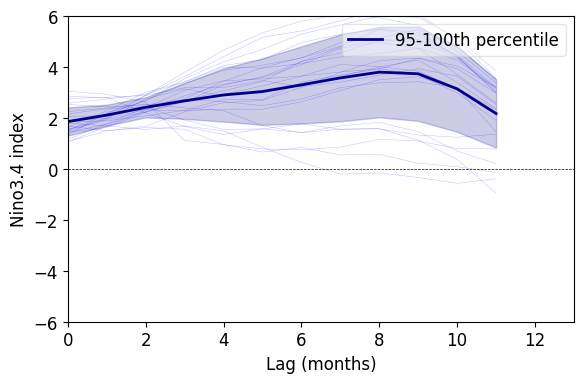

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))
for init_time in trajectories['init_time']:
    ax.plot(trajectories.sel(init_time=init_time)['lag'], trajectories.sel(init_time=init_time), color='blue', linewidth=0.3, alpha=0.3)
pl = ax.plot(trajectories['lag'], trajectories.mean(dim='init_time'), color='darkblue', linewidth=2, label=f"{percentiles[0]}-{percentiles[1]}th percentile")
ax.fill_between(trajectories['lag'], trajectories.mean(dim='init_time')-trajectories.std(dim='init_time'), trajectories.mean(dim='init_time')+trajectories.std(dim='init_time'),
                color=pl[0].get_color(), alpha=0.2)

ax.set_ylim(-6, 6)
ax.set_xlim(0, 13)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel("Lag (months)")
ax.set_ylabel("Nino3.4 index")
ax.legend(loc=1)

## Load metrics from experiments and compute high/low skill cases

In [71]:
load_experiments = ['LIM', 'LSTM', 'LIM+LSTM']
datasplit = 'test'
score_name = 'spread_skill'

scores = {}
for exp_name in load_experiments:
    exp = get_model_specs_by_name(experiments, f"{exp_name} (n18000)")
    if exp is None:
        print(f"Experiment {exp_name} not found")
        continue
    scores[exp_name] = xr.open_dataset(exp['paths'][0] + f'/metrics/timescore_{score_name}_{datasplit}.nc')

Select initial condition based on the percentile of their projection on the optimal pattern

In [72]:
def project_on_optimal_initial_pc(z, optimal_init_pc, init_month, tau):
    """ Project the data on the optimal initial pattern."""
    # Select initial dates
    idx_init_times = np.argwhere(
        (z.time.dt.month.values == init_month)
    ).flatten()[:-tau]
    z_init = z.isel(time=idx_init_times)

    # Project optimal initial and evolved patterns onto the data 
    opt_init = optimal_init_pc.sel(month=init_month, lag=tau)

    projection = xr.DataArray(data=opt_init.data @ z_init.data.T, 
                                     coords=dict(time=z_init['time'].data))
    return projection 

In [73]:
percentiles = ['lower', 'upper']
percentile_range = [[0, 10], [90, 100]]


scores_perc = {}
for exp_name, score in scores.items():
    print(f"Compute percentile score of {exp_name}!")

    # Loop over lags
    score_lag_arr = []
    for tau in score['lag'].values:
        # Loop over initial months
        score_month_arr = []
        for init_month in optimal_init_pc['month'].data:
            # Get optimal initial dates
            z = data[datasplit]
            proj_opt_init = project_on_optimal_initial_pc(z, optimal_init_pc, init_month, tau)
            proj_opt_init = np.abs(proj_opt_init)

            # Loop over percentiles
            score_perc = []
            for (pmin, pmax) in percentile_range:
                idx = np.where(
                    (proj_opt_init.data >= np.percentile(proj_opt_init, pmin))
                    & (proj_opt_init.data <= np.percentile(proj_opt_init, pmax))
                )[0]
                target_dates = preproc.add_to_cftime(proj_opt_init.time[idx].values, n_month=tau)
                target_dates = np.intersect1d(target_dates,
                                            score.time.values)

                score_perc.append(
                    score.sel(time=target_dates, lag=tau).mean('time')
                )
            score_month_arr.append(
                xr.concat(score_perc, dim=pd.Index(percentiles, name='percentile'))
            )
        score_lag_arr.append(
                xr.concat(score_month_arr, dim=pd.Index(optimal_init_pc['month'].data, name='init_month'))
        )
    scores_perc[f"{exp_name}"] = xr.concat(score_lag_arr, dim=pd.Index(score['lag'].data, name='lag'))

Compute percentile score of LIM!
Compute percentile score of LSTM!
Compute percentile score of LIM+LSTM!


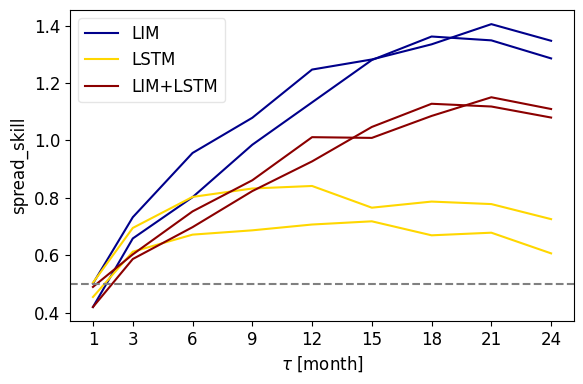

In [74]:
# Average score
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1,1,1)
for exp_name, score in scores_perc.items():
    exp_specs = get_model_specs_by_name(experiments, exp_name)
    clr = exp_specs['color']
    for i, p in enumerate(score['percentile'].values):
        score['ssta'].sel(percentile=p).mean(dim='init_month').plot(
            ax=ax, color=clr, label=exp_name if i == 0 else None)

ax.set_title("")
ax.set_xlabel(r'$\tau$ [month]')
_ = ax.set_xticks(score['lag'])
ax.set_ylabel(score_name)
ax.axhline(0.5, linestyle='--', color='gray')
ax.legend()

### Combined plot

array([<GeoAxes: >, <GeoAxes: >,
       <Axes: xlabel='$\\tau$ [month]', ylabel='ACC'>], dtype=object)

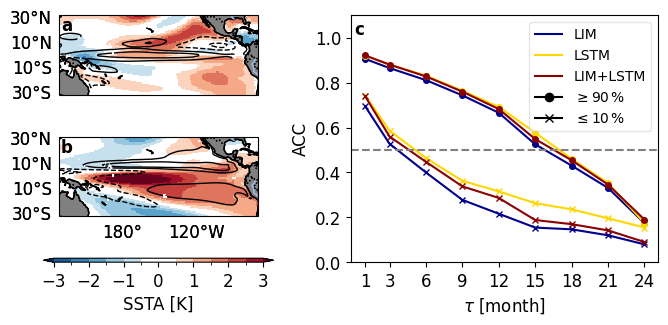

In [61]:
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
reload(gpl)

labels = {'lower': '0-10%', 'upper': '90-100%'}
proj = ctp.crs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(7, 3.4))
gs = gridspec.GridSpec(3, 2, width_ratios=[3,4], height_ratios=2*[2]+[0.1])
axs = []


# Plot maps 
# ======================================================================================
init_month, tau = 4, 12
pltargs = {'ssta': dict(vmin=-3, vmax=3, eps=0.5, cmap='RdBu_r', centercolor='white'),
           'ssha': dict(kwargs_pl={'colors':'k', 'levels' :[-2.5, -1.25, 1.25, 2.5], 
                            'linewidths': 1}, zerolinecolor=None, add_inline_labels=False)}
# Optimal initial pattern
ax = fig.add_subplot(gs[0, 0], projection=proj)
axs.append(ax)
im = gpl.plot_map(optimal_init_map['ssta'].sel(month=init_month, lag=tau), ax=ax, 
             central_longitude=180, **pltargs['ssta'], add_bar=False,
             kwargs_cb=dict(label="Optimal initial", orientation='horizontal')
)
im2 = gpl.plot_contour(optimal_init_map['ssha'].sel(month=init_month, lag=tau), ax=ax,
                       central_longitude=180, **pltargs['ssha'],
                       kwargs_labels=dict(fmt='%.2f'))
#ax.set_title("Optimal initial")
im['gl'].bottom_labels = False
im2['gl'].bottom_labels = False

# Optimal evolved pattern
ax = fig.add_subplot(gs[1, 0], projection=proj)
axs.append(ax)
im = gpl.plot_map(optimal_evolved_map['ssta'].sel(month=init_month, lag=tau), ax=ax, 
             central_longitude=180, **pltargs['ssta'], add_bar=False,
             kwargs_cb=dict(label="Evolved optimal initial", orientation='horizontal')
)
im2 = gpl.plot_contour(optimal_evolved_map['ssha'].sel(month=init_month, lag=tau), ax=ax,
                       central_longitude=180, **pltargs['ssha'],
                       kwargs_labels=dict(fmt='%.2f'))
#ax.set_title("Evolved optimal")

ax = fig.add_subplot(gs[2, 0])
cbar = plt.colorbar(im['im'], cax=ax, orientation='horizontal', label='SSTA [K]')




# Average score
markers = ['x', 'o']
ax = fig.add_subplot(gs[:, 1])
axs.append(ax)
for exp_name, score in scores_perc.items():
    exp_specs = get_model_specs_by_name(experiments, exp_name)
    clr = exp_specs['color']
    for i, p in enumerate(score['percentile'].values):
        score['ssta'].sel(percentile=p).mean(dim='init_month').plot(
            ax=ax, color=clr, label=exp_name if i == 0 else None,
            marker=markers[i], markersize=4)

ax.set_title("")
ax.set_xlabel(r'$\tau$ [month]')
_ = ax.set_xticks(score['lag'])
ax.set_ylabel(r"ACC")
ax.set_ylim(0.0, 1.1)
ax.axhline(0.5, linestyle='--', color='gray')


# Legend
lines = []
for exp_name, score in scores_perc.items():
    exp_specs = get_model_specs_by_name(experiments, exp_name)
    lines.append(mlines.Line2D([], [], color=exp_specs['color'], linestyle='-', label=exp_name))
lines.append(mlines.Line2D([], [], color='black', marker='o', linestyle='-', label=r'$\geq 90\, \%$'))
lines.append(mlines.Line2D([], [], color='black', marker='x', linestyle='-', label=r'$\leq 10\, \%$'))
plt.legend(handles=lines, loc=0, fontsize='small')


gpl.enumerate_axes(axs, pos_x=0.01, pos_y=[0.98, 0.98, 0.98])

### Spread-skill

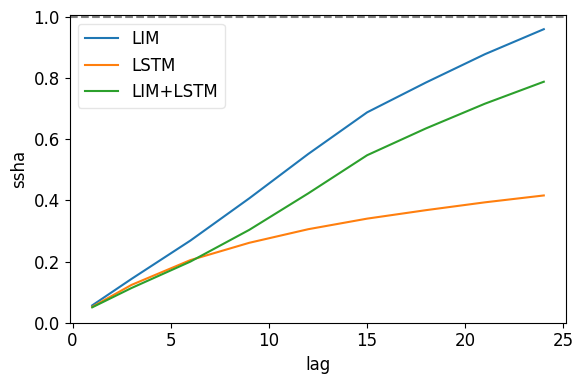

In [134]:
load_experiments = ['LIM', 'LSTM', 'LIM+LSTM']
datasplit = 'test'

fig, ax = plt.subplots(figsize=(6, 4))
for exp_name in load_experiments:
    exp = get_model_specs_by_name(experiments, f"{exp_name} (n18000)")
    if exp is None:
        print(f"Experiment {exp_name} not found")
        continue
    score = xr.open_dataset(exp['paths'][0] + f'/metrics/timescore_spread_skill_{datasplit}.nc')

    score['ssha'].mean(dim='time').plot(ax=ax, label=exp_name)

ax.set_ylim(0,None)
ax.axhline(1.0, linestyle='--', color='gray')
ax.legend()

In [129]:
load_experiments = ['LIM', 'LSTM', 'LIM+LSTM']
datasplit = 'test'

spread, skill = {}, {}
for exp_name in load_experiments:
    exp = get_model_specs_by_name(experiments, f"{exp_name} (n18000)")
    if exp is None:
        print(f"Experiment {exp_name} not found")
        continue
    spread[exp_name] = xr.open_dataset(exp['paths'][0] + f'/metrics/timescore_spread_{datasplit}.nc')
    skill[exp_name] = np.sqrt(xr.open_dataset(exp['paths'][0] + f'/metrics/timescore_mse_{datasplit}.nc'))

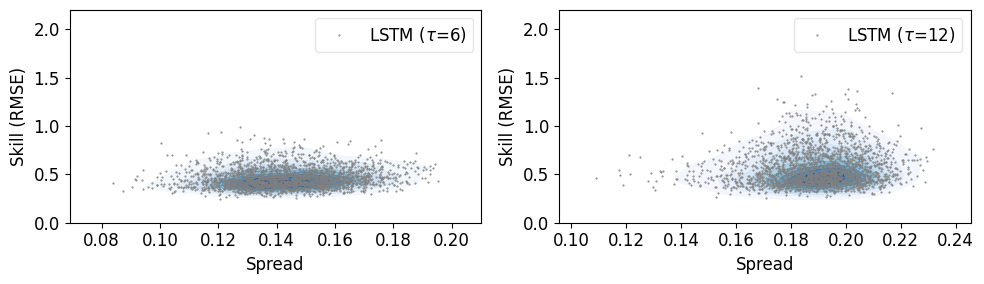

In [130]:
import seaborn as sns
exp_name = 'LSTM'
lag_arr = [6, 12]
nrows = len(lag_arr)
fig, axs = plt.subplots(1, nrows, figsize=(5*nrows, 3))
for i, lag in enumerate(lag_arr):
    ax = axs[i]

    ax.plot(spread[exp_name]['ssta'].sel(lag=lag), skill[exp_name]['ssta'].sel(lag=lag), '.', markersize=1, color='grey', label=rf"{exp_name} ($\tau$={lag})")
    sns.kdeplot(x=spread[exp_name]['ssta'].sel(lag=lag).data, y=skill[exp_name]['ssta'].sel(lag=lag).data, ax=ax,
            alpha=0.8, fill=True, cmap='Blues')

    ax.legend()
    ax.set_xlabel('Spread')
    ax.set_ylabel('Skill (RMSE)')
    ax.set_ylim(0, 2.2)


## Nino indices

In [122]:
load_experiments = ['LIM', 'LSTM', 'LIM+LSTM']
datasplit = 'test'

nino_scores, nino_scores_month = {}, {}
for exp_name in load_experiments:
    exp = get_model_specs_by_name(experiments, f"{exp_name} (n18000)")
    if exp is None:
        print(f"Experiment {exp_name} not found")
        continue
    nino_frcst = xr.open_dataset(exp['paths'][0] + '/metrics/nino_frcst_test.nc').transpose('time', 'member', 'lag')
    nino_target = xr.open_dataset(exp['paths'][0] + '/metrics/nino_target_test.nc').transpose('time','lag')

    nino_scores_exp, nino_scores_exp_month = metric.time_series_score(nino_frcst, nino_target)
    nino_scores[exp_name] = nino_scores_exp
    nino_scores_month[exp_name] = nino_scores_exp_month

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

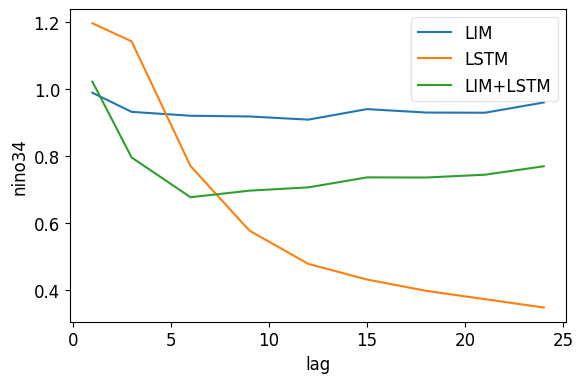

In [135]:
fig, ax = plt.subplots(figsize=(6, 4))
for exp_name, score in nino_scores.items():
    score['spread_skill']['nino34'].plot(ax=ax, label=exp_name)
ax.legend()